### Если вы хотите выполнять эту домашку на своём компе, то вам придётся даунгрейднуть gym. Вот код который должен выполниться сам, но возможно ещё что-то вам поломает.

### Или просто делайте её в гугл колабе, там всё само поставится и будет ок, но в гугл колабе не работает рендер (ImportError: Library "GLU" not found.)


In [1]:
!pip install wheel==0.38.4
!pip install setuptools==66
!pip install gym==0.21.0

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Seminar: Monte-carlo tree search

In this seminar, we'll implement a vanilla MCTS planning and use it to solve some Gym envs.

But before we do that, we first need to modify gym env to allow saving and loading game states to facilitate backtracking.

In [3]:
from gym.core import Wrapper
from pickle import dumps,loads
from collections import namedtuple

#a container for get_result function below. Works just like tuple, but prettier
ActionResult = namedtuple("action_result",("snapshot","observation","reward","is_done","info"))


class WithSnapshots(Wrapper):
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset, step and render directly for convenience.
    - s, r, done, _ = self.step(action)   #step, same as self.env.step(action)
    - self.render(close=True)             #close window, same as self.env.render(close=True)
    """


    def get_snapshot(self):
        """
        :returns: environment state that can be loaded with load_snapshot
        Snapshots guarantee same env behaviour each time they are loaded.

        Warning! Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.

        Developer Note: Make sure the object you return will not be affected by
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env.
        In case of doubt, use pickle.dumps or deepcopy.

        """
        self.close() #close popup windows since we can't pickle them
        return dumps(self.env)

    def load_snapshot(self,snapshot):
        """
        Loads snapshot as current env state.
        Should not change snapshot inplace (in case of doubt, deepcopy).
        """

        assert not hasattr(self,"_monitor") or hasattr(self.env,"_monitor"), "can't backtrack while recording"

        self.close() #close popup windows since we can't load into them
        self.env = loads(snapshot)

    def get_result(self,snapshot,action):
        """
        A convenience function that
        - loads snapshot,
        - commits action via self.step,
        - and takes snapshot again :)

        :returns: next snapshot, next_observation, reward, is_done, info

        Basically it returns next snapshot and everything that env.step would have returned.
        """
        state = self.load_snapshot(snapshot)
        s, r, done, i = self.step(action)
        nextsn = self.get_snapshot()

        return ActionResult(nextsn,    #fill in the variables
                            s,
                            r, done, i)


### try out snapshots (2 pts):


In [4]:
#make env
env = WithSnapshots(gym.make("CartPole-v0"))
env.reset()

n_actions = env.action_space.n

initial_state:


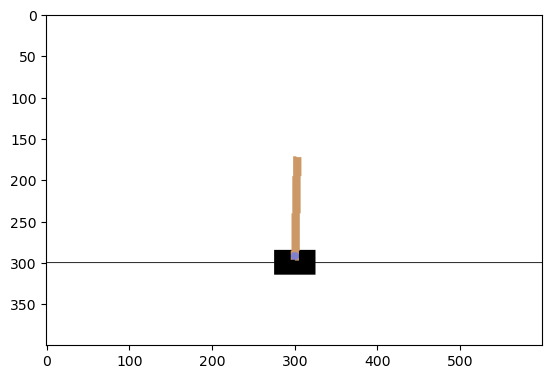

In [5]:
!pip install pyglet==1.5.27
print("initial_state:")

plt.imshow(env.render('rgb_array'))

#create first snapshot
first = env.get_snapshot()

Whoops! We died!
final state:


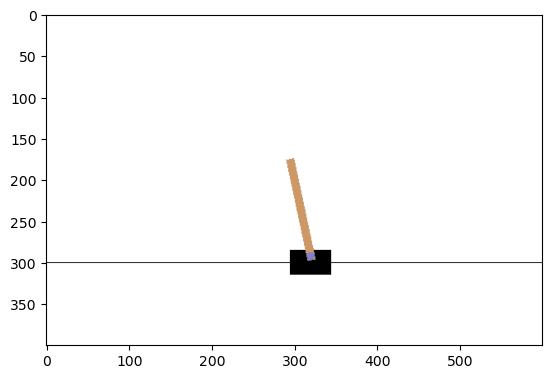

In [6]:
#play without making snapshots (faster)
while True:
    is_done = env.step(env.action_space.sample())[2]
    if is_done:
        print("Whoops! We died!")
        break

print("final state:")
plt.imshow(env.render('rgb_array'))
plt.show()


In [7]:
#get outcome (snapshot, observation, reward, is_done, info)
res = env.get_result(first,env.action_space.sample())

snap1, observation, reward = res[:3]

#second step
res2 = env.get_result(snap1,env.action_space.sample())



After loading snapshot


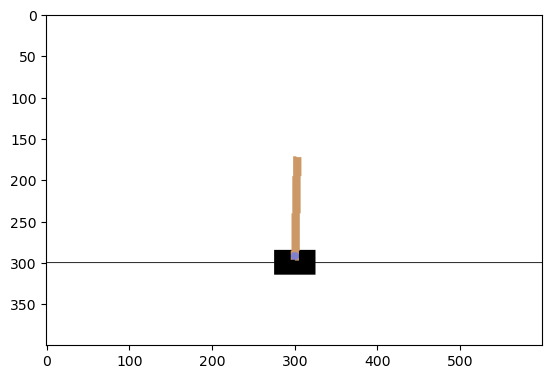

In [8]:
#reload initial state from created first snapshot
env.load_snapshot(first)

print("\n\nAfter loading snapshot")
plt.imshow(env.render('rgb_array'))
plt.show()

# MCTS: Monte-Carlo tree search

In this section, we'll implement the vanilla MCTS algorithm with UCB1-based node selection.

We will start by implementing the `Node` class - a simple class that acts like MCTS node and supports some of the MCTS algorithm steps.

This MCTS implementation makes some assumptions about the environment, you can find those _in the notes section at the end of the notebook_.

In [9]:
assert isinstance(env,WithSnapshots)
import math

In [10]:
class Node:
    """ a tree node for MCTS """

    #metadata:
    parent = None          #parent Node
    value_sum = 0.         #sum of state values from all visits (numerator)
    times_visited = 0      #counter of visits (denominator)


    def __init__(self,parent,action,):
        """
        Creates and empty node with no children.
        Does so by commiting an action and recording outcome.

        :param parent: parent Node
        :param action: action to commit from parent Node

        """

        self.parent = parent
        self.action = action
        self.children = set()       #set of child nodes

        #get action outcome and save it
        res = env.get_result(parent.snapshot,action)
        self.snapshot,self.observation,self.immediate_reward,self.is_done,_ = res


    def is_leaf(self):
        return len(self.children)==0

    def is_root(self):
        return self.parent is None

    def get_mean_value(self):
        return self.value_sum / self.times_visited if self.times_visited !=0 else 0

    def ucb_score(self,scale=10,max_value=1e100):
        """
        Computes ucb1 upper bound using current value and visit counts for node and it's parent.

        :param scale: Multiplies upper bound by that. From hoeffding inequality, assumes reward range to be [0,scale].
        :param max_value: a value that represents infinity (for unvisited nodes)

        """

        if self.times_visited == 0:
            return max_value

        #compute ucb-1 additive component (to be added to mean value) (exploration)
        #hint: you can use self.parent.times_visited for N times node was considered,
        # and self.times_visited for n times it was visited
        
        #https://habr.com/ru/companies/selectel/articles/794658/ - эта статья просто имба
        U = math.sqrt(2) * math.sqrt(math.log(0 if self.is_root() else self.parent.times_visited) / self.times_visited)

        return self.get_mean_value() + scale*U


    #MCTS steps

    def select_best_leaf(self):
        """
        Picks the leaf with highest priority to expand
        Does so by recursively picking nodes with best UCB-1 score until it reaches the leaf.

        """
        if self.is_leaf():
            return self

        children = self.children

        best_child = None
        max_score = float("-inf")
        for child in self.children:
            score = child.ucb_score()
            if score > max_score:
                max_score = score
                best_child = child
        
        return best_child.select_best_leaf()

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.
        Then returns one of those children.
        """

        assert not self.is_done, "can't expand from terminal state"

        for action in range(n_actions):
            self.children.add(Node(self,action))

        return self.select_best_leaf()

    def rollout(self,t_max=10**4):
        """
        Play the game from this state to the end (done) or for t_max steps.

        On each step, pick action at random (hint: env.action_space.sample()).

        Compute sum of rewards from current state till
        Note 1: use env.action_space.sample() for random action
        Note 2: if node is terminal (self.is_done is True), just return 0

        """

        #set env into the appropriate state
        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done

        totalRew = 0

        if is_done:
            return 0

        cur = self.snapshot

        for t in range(t_max):
            action = env.action_space.sample()
            res = env.get_result(cur, action)
            totalRew += res[2]
            cur = res[0]
            if res[3]:
                break
        

        return totalRew

    def propagate(self,child_value):
        """
        Uses child value (sum of rewards) to update parents recursively.
        """
        #compute node value
        my_value = self.immediate_reward + child_value

        #update value_sum and times_visited
        self.value_sum+=my_value
        self.times_visited+=1

        #propagate upwards
        if not self.is_root():
            self.parent.propagate(my_value)

    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

In [12]:
class Root(Node):
    def __init__(self,snapshot,observation):
        """
        creates special node that acts like tree root
        :snapshot: snapshot (from env.get_snapshot) to start planning from
        :observation: last environment observation
        """

        self.parent = self.action = None
        self.children = set()       #set of child nodes

        #root: load snapshot and observation
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done=False

    @staticmethod
    def from_node(node):
        """initializes node as root"""
        root = Root(node.snapshot,node.observation)
        #copy data
        copied_fields = ["value_sum","times_visited","children","is_done"]
        for field in copied_fields:
            setattr(root,field,getattr(node,field))
        return root

## Main MCTS loop (4 pts)

With all we implemented, MCTS boils down to a trivial piece of code.

In [13]:
def plan_mcts(root,n_iters=100):
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    for _ in range(n_iters):

        node = root.select_best_leaf()

        if node.is_done:
            node.propagate(0)

        else: #node is not terminal
            best = node.expand()
            best.rollout(int(1e4))
            best.propagate(reward)



## Plan and execute (3 pts)
In this section, we use the MCTS implementation to find optimal policy.

In [14]:
root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot,root_observation)

In [15]:
#plan from root:
plan_mcts(root,n_iters=10000)

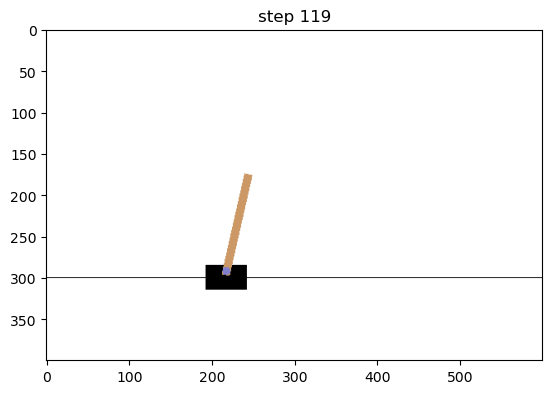

Finished with reward =  120.0


In [16]:
from IPython.display import clear_output
from itertools import count
from gym.wrappers import Monitor

total_reward = 0                #sum of rewards
test_env = loads(root_snapshot) #env used to show progress

for i in count():

    #get best child
    best_child = None
    max_score = float("-inf")
    for child in root.children:
        score = child.get_mean_value()
        if score > max_score:
            max_score = score
            best_child = child

    #take action
    s,r,done,_ = test_env.step(best_child.action)

    #show image
    clear_output(True)
    plt.title("step %i"%i)
    plt.imshow(test_env.render('rgb_array'))
    plt.show()

    total_reward += r
    if done:
        print("Finished with reward = ",total_reward)
        break

    #discard unrealized part of the tree [because not every child matters :(]
    for child in root.children:
        if child != best_child:
            child.safe_delete()

    #declare best child a new root
    root = Root.from_node(best_child)

    root.expand()

    assert not root.is_leaf(), "We ran out of tree! Need more planning! Try growing tree right inside the loop."

    #you may want to expand tree here
    #<your code here>
    #optional


## Report (1 pts)

Надеюсь поставите 5 баллов хотя бы, чтобы у меня была 5 🥺🥺🥺

В целом здесь мне понравилась сама идея - дерево Монте-Карло (это очень гениально). С точки зрения реализации почти всё было написано. 
P.S: я немного увеличил везде константы, чтобы лучше обучилось для последнего номераю